## Purpose

This notebook uses the CSV file outputted by ```fetch_data_postgres.ipynb```, performs preprocessing on it, and trains a linear regression machine learning model that predicts the house sale price given the information in the CSV.

Currently the model is fitted to house sale data only, however training the model on condo sale data should be almost the same as it only has 1 extra column (Condominium number) than house sale data.

### Input

This notebook requires the CSV file that was created by ```fetch_data_postgres.ipynb``` in the ```output``` folder

### Output

Three ```.joblib``` files will be outputted, which will be used to make new predictions in our Flask server: 

1. ```ohe.joblib``` - the fitted One Hot Encoder to transform new prediction's categorical data into a '1s and 0s' dataframe
2. ```num.joblib``` - the fitted Standard Scaler to transform new prediction's numerical data into a range between the min-max scale
3. ```model.joblib``` - the trained Linear Regression model to predict sale prices of new data

In [1]:
import pandas as pd
from joblib import dump

import sklearn.preprocessing as sklprocess
import sklearn.model_selection as modelselection
import sklearn.linear_model as linearmodel

In [2]:
# Set maximum number of rows and columns to display for any Pandas dataframe

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Read in the input CSV file

data = pd.read_csv("../datasets/output/fetch_postgres.csv")

# Inspect the dataframe

data.sample(2)

C:\Users\arshb\AppData\Local\Temp\ipykernel_14712\4217301822.py:8: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../datasets/output/fetch_postgres.csv")


,PropertyType,Pool,Rooms,Zoning,Basement,Geometry,Status 1,Status 2,Status 3,Status 4,Status 5,Sale Year,Detail URL,Fire Place,Sale Month,Sale Price,Year Built,Roll Number,Street Name,Street Type,Unit Number,Full Address,Building Type,Market Region,Street Number,Street Suffix,Assessment Date,Attached Garage,Basement Finish,Detached Garage,Air Conditioning,Assessed Value 1,Assessed Value 2,Assessed Value 3,Assessed Value 4,Assessed Value 5,Property Class 1,Property Class 2,Property Class 3,Property Class 4,Property Class 5,Street Direction,Property Use Code,Proposed Status 1,Proposed Status 2,Proposed Status 3,Proposed Status 4,Proposed Status 5,Total Living Area,Assessed Land Area,Neighbourhood Area,Multiple Residences,Number Floors Condo,Property Influences,Total Assessed Value,Time Adjust Sale Price,Current Assessment Year,Proposed Assessment Date,Proposed Assessment Year,Proposed Property Class 1,Proposed Property Class 2,Proposed Property Class 3,Proposed Property Class 4,Proposed Property Class 5,Sewer Frontage Measurement,Water Frontage Measurement,Proposed Assessment Value 1,Proposed Assessment Value 2,Proposed Assessment Value 3,Proposed Assessment Value 4,Proposed Assessment Value 5,Total Proposed Assessment Value
2641,house,No,5.0,R1M - RES - S F - MEDIUM,Yes,MULTIPOLYGON (((-97.104352527645 49.8042547358...,TAXABLE,NaN,NaN,NaN,NaN,2016,http://www.winnipegassessment.com/AsmtPub/engl...,No,6,"$275,000",1985.0,8006272000,PADDINGTON,ROAD,NaN,587 PADDINGTON ROAD,ONE STOREY,"10, NEW ST BONIFACE/NEW ST VITAL",587.0,NaN,04/01/2018 12:00:00 AM,No,Yes,No,Yes,297000.0,NaN,NaN,NaN,NaN,RESIDENTIAL 1,NaN,NaN,NaN,NaN,NaN,RESSD - DETACHED SINGLE DWELLING,TAXABLE,NaN,NaN,NaN,NaN,980.0,4181.0,RIVER PARK SOUTH,No,NaN,"BACK LANE,BUS ROUTE,LIGHT TRAFFIC",297000.0,"$286,000",2022.0,04/01/2021 12:00:00 AM,2023.0,RESIDENTIAL 1,NaN,NaN,NaN,NaN,38.13,38.11,323000.0,NaN,NaN,NaN,NaN,323000.0
37494,house,No,10.0,R1M - RES - S F - MEDIUM,Yes,MULTIPOLYGON (((-97.195144587745 49.7845653371...,TAXABLE,NaN,NaN,NaN,NaN,2019,http://www.winnipegassessment.com/AsmtPub/engl...,Yes,9,"$569,000",2017.0,3092990880,DEL MONICA,ROAD,NaN,249 DEL MONICA ROAD,TWO STOREY,"8, FORT GARRY / LINDENWOODS",249.0,NaN,04/01/2018 12:00:00 AM,Yes,Yes,No,Yes,643000.0,NaN,NaN,NaN,NaN,RESIDENTIAL 1,NaN,NaN,NaN,NaN,NaN,RESSD - DETACHED SINGLE DWELLING,TAXABLE,NaN,NaN,NaN,NaN,2626.0,9193.0,BRIDGWATER TRAILS,No,NaN,NaN,643000.0,"$614,000",2022.0,04/01/2021 12:00:00 AM,2023.0,RESIDENTIAL 1,NaN,NaN,NaN,NaN,44.20,44.20,658000.0,NaN,NaN,NaN,NaN,658000.0


In [3]:
# Check which and how many rows have the sale price value as a float (instead of being integer) so we can convert them to integer and check again

data[data['Sale Price'].str.contains(r'\.')]

# About a thousand rows that have a decimal value in sale price column

,PropertyType,Pool,Rooms,Zoning,Basement,Geometry,Status 1,Status 2,Status 3,Status 4,Status 5,Sale Year,Detail URL,Fire Place,Sale Month,Sale Price,Year Built,Roll Number,Street Name,Street Type,Unit Number,Full Address,Building Type,Market Region,Street Number,Street Suffix,Assessment Date,Attached Garage,Basement Finish,Detached Garage,Air Conditioning,Assessed Value 1,Assessed Value 2,Assessed Value 3,Assessed Value 4,Assessed Value 5,Property Class 1,Property Class 2,Property Class 3,Property Class 4,Property Class 5,Street Direction,Property Use Code,Proposed Status 1,Proposed Status 2,Proposed Status 3,Proposed Status 4,Proposed Status 5,Total Living Area,Assessed Land Area,Neighbourhood Area,Multiple Residences,Number Floors Condo,Property Influences,Total Assessed Value,Time Adjust Sale Price,Current Assessment Year,Proposed Assessment Date,Proposed Assessment Year,Proposed Property Class 1,Proposed Property Class 2,Proposed Property Class 3,Proposed Property Class 4,Proposed Property Class 5,Sewer Frontage Measurement,Water Frontage Measurement,Proposed Assessment Value 1,Proposed Assessment Value 2,Proposed Assessment Value 3,Proposed Assessment Value 4,Proposed Assessment Value 5,Total Proposed Assessment Value
11,house,No,6.0,R1M - RES - S F - MEDIUM,Yes,MULTIPOLYGON (((-96.994626906911 49.8946507737...,TAXABLE,NaN,NaN,NaN,NaN,2016,http://www.winnipegassessment.com/AsmtPub/engl...,No,8,"$272,067.80",2016.0,9010473620,MELROSE,AVENUE,NaN,415 MELROSE AVENUE E,TWO STOREY,"1, TRANSCONA",415.0,NaN,04/01/2018 12:00:00 AM,No,No,No,Yes,302000.0,NaN,NaN,NaN,NaN,RESIDENTIAL 1,NaN,NaN,NaN,NaN,E,RESSD - DETACHED SINGLE DWELLING,TAXABLE,NaN,NaN,NaN,NaN,1373.0,2499.0,MELROSE,No,NaN,NaN,302000.0,"$281,900",2022.0,04/01/2021 12:00:00 AM,2023.0,RESIDENTIAL 1,NaN,NaN,NaN,NaN,25.0,25.0,331000.0,NaN,NaN,NaN,NaN,331000.0
148,house,No,5.0,R1M - RES - S F - MEDIUM,Yes,MULTIPOLYGON (((-97.01062029095 49.89629815718...,TAXABLE,NaN,NaN,NaN,NaN,2017,http://www.winnipegassessment.com/AsmtPub/engl...,No,2,"$288,662.70",2017.0,9010473645,VICTORIA,AVENUE,NaN,343 VICTORIA AVENUE W,TWO STOREY,"1, TRANSCONA",343.0,NaN,04/01/2018 12:00:00 AM,No,No,Yes,No,304000.0,NaN,NaN,NaN,NaN,RESIDENTIAL 1,NaN,NaN,NaN,NaN,W,RESSD - DETACHED SINGLE DWELLING,TAXABLE,NaN,NaN,NaN,NaN,1256.0,2500.0,VICTORIA WEST,No,NaN,PARK,304000.0,"$295,900",2022.0,04/01/2021 12:00:00 AM,2023.0,RESIDENTIAL 1,NaN,NaN,NaN,NaN,25.0,25.0,334000.0,NaN,NaN,NaN,NaN,334000.0
244,house,No,6.0,R1M - RES - S F - MEDIUM,Yes,MULTIPOLYGON (((-96.990597942419 49.8963012337...,TAXABLE,NaN,NaN,NaN,NaN,2017,http://www.winnipegassessment.com/AsmtPub/engl...,No,3,"$281,007.70",2016.0,9000478000,VICTORIA,AVENUE,NaN,539 VICTORIA AVENUE E,ONE STOREY,"1, TRANSCONA",539.0,NaN,04/01/2018 12:00:00 AM,No,Yes,No,Yes,331000.0,NaN,NaN,NaN,NaN,RESIDENTIAL 1,NaN,NaN,NaN,NaN,E,RESSD - DETACHED SINGLE DWELLING,TAXABLE,NaN,NaN,NaN,NaN,1180.0,4304.0,KERN PARK,No,NaN,NaN,331000.0,"$287,500",2022.0,04/01/2021 12:00:00 AM,2023.0,RESIDENTIAL 1,NaN,NaN,NaN,NaN,43.0,43.0,363000.0,NaN,NaN,NaN,NaN,363000.0
597,house,No,6.0,R1M - RES - S F - MEDIUM,Yes,MULTIPOLYGON (((-96.974455860947 49.8961842631...,TAXABLE,NaN,NaN,NaN,NaN,2016,http://www.winnipegassessment.com/AsmtPub/engl...,Yes,9,"$371,595.60",2016.0,9010455100,BILL LARKIN,LANE,NaN,19 BILL LARKIN LANE,TWO STOREY,"1, TRANSCONA",19.0,NaN,04/01/2018 12:00:00 AM,Yes,No,No,Yes,397000.0,NaN,NaN,NaN,NaN,RESIDENTIAL 1,NaN,NaN,NaN,NaN,NaN,RESSD - DETACHED SINGLE DWELLING,TAXABLE,NaN,NaN,NaN,NaN,1710.0,5063.0,CANTERBURY PARK,No,NaN,NaN,397000.0,"$384,200",2022.0,04/01/2021 12:00:00 AM,2023.0,RESIDENTIAL 1,NaN,NaN,NaN,NaN,43.0,43.0,438000.0,NaN,NaN,NaN,NaN,438000.0
599,house,No,6.0,R1M - RES - S F - MEDIUM,Yes,MULTIPOLYGON (((-96.974653693196 49.8962485204...,TAXABLE,NaN,NaN,NaN,NaN,2016,http://www.winnipegassessment.com/AsmtPub/engl...,No,8,"$341,085.20",2016.0,9010455000,BILL LARKIN,LANE,NaN,23 BILL LARKIN LANE,ONE STOREY,"1, TRANSCONA",23.0,NaN,04/01/2018 12:00:00 AM,Yes,No,No,Yes

In [4]:
# Replace the below column's missing values from NaN to 0.0 float value and convert it to an integer type

data['Total Assessed Value'] = data['Total Assessed Value'].fillna(0.0).astype(int)


In [5]:
# Using RegEx, convert Sale Price column value from strings to floats (for example: $500,000.75 -> 500000.75)

data['Sale Price'] = data['Sale Price'].str.replace(r'([^0-9.-]+)', "")

# Convert from float to integer (ignore the decimal values)
data['Sale Price'] = data['Sale Price'].str.replace(r'(\..*$)', "")

# Convert from integer string to integer data type
data['Sale Price'] = pd.to_numeric(data['Sale Price'])

# Inspect the column to ensure it has integer values only
data['Sale Price']

C:\Users\arshb\AppData\Local\Temp\ipykernel_14712\176790126.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Sale Price'] = data['Sale Price'].str.replace(r'([^0-9.-]+)', "")
C:\Users\arshb\AppData\Local\Temp\ipykernel_14712\176790126.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Sale Price'] = data['Sale Price'].str.replace(r'(\..*$)', "")


0        154750
1        187500
2        178500
3        153217
4        180000
          ...  
39033    930000
39034    841500
39035    430000
39036    440000
39037    420000
Name: Sale Price, Length: 39038, dtype: int64

In [6]:
# Check how many rows that have atleast 1 missing values for each column

list = data.isna().sum()

print(list)


PropertyType                           0
Pool                                1949
Rooms                               1951
Zoning                              1869
Basement                            1960
Geometry                            1869
Status 1                            1869
Status 2                           38973
Status 3                           39038
Status 4                           39038
Status 5                           39038
Sale Year                              0
Detail URL                          1869
Fire Place                          1949
Sale Month                             0
Sale Price                             0
Year Built                          1950
Roll Number                            0
Street Name                         1869
Street Type                         1949
Unit Number                        39016
Full Address                        1869
Building Type                       1950
Market Region                       1869
Street Number   

In [7]:
# Remove the columns where >80% of its value are NaN (missing)

cols_to_drop = ['Time Adjust Sale Price', 'PropertyType', 'Street Suffix', 'Unit Number', 'Number Floors Condo', 'Street Direction', 'Geometry', 'Detail URL', 'Roll Number', 'Street Name', 'Full Address', 'Street Number', 'Assessment Date', 'Proposed Assessment Date', 'Proposed Assessment Year', 'Proposed Assessment Value 1', 'Total Proposed Assessment Value']

# Since some of these columns have incrementing names from 2-5, we loop through them and add them to our list of columns to be removed from dataframe

for i in range(2,6):

    i = str(i)
    cols_to_drop = cols_to_drop + ['Proposed Assessment Value ' + i, 'Proposed Property Class ' + i, 'Proposed Status ' + i, 'Property Class ' + i, 'Assessed Value ' + i, 'Status ' + i]

# Remove the columns in our list (axis = 0 means drop row, 1 means drop column)
data = data.drop(cols_to_drop, axis=1)  

In [8]:
"""
Purpose:
This function returns the number of times each unique value appears in a given column of a dataframe

Parameters:
col - name of the column to perform value count on

Return:
Pandas Series with 2 values: unique string and its count
"""

def get_num_unique_vals(col):

    #return data.groupby(col).count()
    return data[col].value_counts().sort_values(ascending=False)

In [9]:
"""
Check if a majority of the rows have a single unique value, in which case it's a useless column that does not help our model much.
We should keep the columns by default as the more information our model has, the better.
But we should remove the columns which have a high percentage of rows with only 1 unique value (such as the case for below column)
as that only serves to convulate our model (atleast when building simple models)
"""

get_num_unique_vals('Status 1')

# Since only 8 rows have a different value other than 'Taxable', we will drop this column

TAXABLE                  37161
TAXABLE SCHOOL EXEMPT        8
Name: Status 1, dtype: int64

In [10]:
get_num_unique_vals('Zoning')

# Although half of rows have 1 unique value, we will keep this column as it has good amounts of indicators that may be helpful in training our model

R1M - RES - S F - MEDIUM      20095
R1L - RES - S F - LARGE        6305
R2 - RES - TWO FAMILY          6149
R1S - RES - S F - SMALL        2793
RMFS - RES - MULTI-FAMILY      1049
RR5 - RURAL RESIDENTIAL-5       283
R1E - RES - S F - ESTATE        129
RMFM - RES - MULTI-FAMILY       108
C1 - COM - NEIGHBOURHOOD         51
RR2 - RURAL RESIDENTIAL-2        50
C2 - COM - COMMUNITY             45
A - AGRICULTURAL                 44
M1 - MANUFCTRNG - LIGHT          30
R14 - SINGLE FAMILY              10
PR1 - PRKS&REC-PASSIVE            8
M3 - MANUFCTRNG - HEAVY           6
M2 - MANUFCTRNG - GENERAL         3
R120 - SINGLE FAMILY              2
PR2 - PRKS&REC-ACTIVE             2
R15 - SINGLE FAMILY               1
M - MULTIPLE-USE                  1
RMFL - RES - MULTI-FAMILY         1
CMU - COMMERCIAL-MIXED USE        1
R135 - SINGLE FAMILY              1
D - DOWNTOWN LIVING               1
120A - SINGLE FAMILY              1
Name: Zoning, dtype: int64

In [11]:
get_num_unique_vals('Street Type')

# We should keep this column as it doesn't have a majority of its rows as a single unique value

AVENUE       11173
STREET        6235
DRIVE         4755
ROAD          3557
CRESCENT      3057
BAY           2943
PLACE         1270
BOULEVARD     1098
WAY            711
COVE           435
COURT          321
GATE           299
LANE           292
TRAIL          173
PATH           136
CLOSE          101
CIRCLE          92
POINT           92
ROW             84
GROVE           49
PARK            40
HIGHWAY         38
WALK            33
TERRACE         23
PROMENADE       18
COMMON          18
SQUARE          18
KEY             13
RIDGE            7
GREEN            3
MEWS             3
RUN              2
Name: Street Type, dtype: int64

In [12]:
get_num_unique_vals('Property Class 1')

# We should remove this column as it has almost all of its entries as 'Residential 1'

RESIDENTIAL 1    37140
RESIDENTIAL 2       20
INSTITUTIONAL        8
OTHER                1
Name: Property Class 1, dtype: int64

In [13]:
get_num_unique_vals('Property Use Code')

# Although the % of rows with a single value is quite high, this column has great indicators (what type of property it is) so we should keep it

RESSD - DETACHED SINGLE DWELLING          33101
RESSS - SIDE BY SIDE                       2376
RESMC - MULTIFAMILY CONVERSION              713
RESRH - ROW HOUSING                         467
RESDU - DUPLEX                              265
RESSU - RESIDENTIAL SECONDARY UNIT          132
VRES1 - VACANT RESIDENTIAL 1                 53
RESGC - RESIDENTIAL GROUP CARE               21
RESTR - TRIPLEX                              21
RESMA - MULTIPLE ATTACHED UNITS              14
VRES2 - VACANT RESIDENTIAL 2                  2
VCOMM - VACANT COMMERCIAL                     1
RESMB - RESIDENTIAL MULTIPLE BUILDINGS        1
RESAP - APARTMENTS                            1
RESOT - RESIDENTIAL OUTBUILDING               1
Name: Property Use Code, dtype: int64

In [14]:
get_num_unique_vals('Property Influences')

# We should remove this column for now due to its large number of unique values
# but for later tinkering around with the model, I believe it can be useful for improving the accuracy of the model 
# by using One Hot Encoding on its top 10 (or another number) most popular values

COMMERCIAL ADJACENT                                                          1420
EXTERNAL CORNER                                                              1162
PARK                                                                         1135
BACK LANE                                                                    1107
BUS ROUTE,MEDIUM TRAFFIC                                                     1050
                                                                             ... 
EXTERNAL CORNER,HYDRO LINES,MEDIUM TRAFFIC                                      1
GOLF COURSE,INTERNAL CORNER                                                     1
BUS ROUTE,COMMERCIAL ADJACENT,HEAVY TRAFFIC,PARK,SEINE RIVER ADJACENT           1
COMMERCIAL INFLUENCE,MEDIUM TRAFFIC,PARK                                        1
COMMERCIAL ADJACENT,COMMUNITY CLUB BUILDING,EXTERNAL CORNER,LIGHT TRAFFIC       1
Name: Property Influences, Length: 665, dtype: int64

In [15]:
get_num_unique_vals('Current Assessment Year')

# Since there is only 1 unique value in this column, we can safely remove it

2022.0    37169
Name: Current Assessment Year, dtype: int64

In [16]:
get_num_unique_vals('Rooms')

# About 20 unique Room number count with no majority rows having a single value, we should keep this column
# For now, we can use One Hot Encoding instead of treating it as a numeric feature
# For Future: is the model more accurate when this column is treated as nomimal category or numeric?

6.0     13720
5.0      9455
7.0      5607
4.0      3214
8.0      3105
9.0      1115
10.0      424
11.0      153
3.0       108
12.0       93
13.0       42
14.0       24
15.0        9
16.0        6
2.0         3
18.0        3
17.0        2
20.0        2
22.0        1
1.0         1
Name: Rooms, dtype: int64

In [17]:
get_num_unique_vals('Neighbourhood Area')

# Good amount of balance, as expected from this column. Most definitely keep this column!

RIVER PARK SOUTH       715
PEGUIS                 684
SAGE CREEK             676
BRIDGWATER TRAILS      659
CHALMERS               648
                      ... 
CENTRAL PARK             1
ST JAMES INDUSTRIAL      1
AIRPORT                  1
CIVIC CENTRE             1
TRAPPISTES               1
Name: Neighbourhood Area, Length: 194, dtype: int64

In [18]:
data[data['Assessed Value 1'] != data['Total Assessed Value']]

# Less than 2k rows where Total Assessed Value column diffes from Assessed Value 1
# Since 'Assessed Value 1' column is used to calculate the 'Total Assessed Value' column, 
# we can safely remove the former column as it doesn't add any extra information to our model

,Pool,Rooms,Zoning,Basement,Status 1,Sale Year,Fire Place,Sale Month,Sale Price,Year Built,Street Type,Building Type,Market Region,Attached Garage,Basement Finish,Detached Garage,Air Conditioning,Assessed Value 1,Property Class 1,Property Use Code,Proposed Status 1,Total Living Area,Assessed Land Area,Neighbourhood Area,Multiple Residences,Property Influences,Total Assessed Value,Current Assessment Year,Proposed Property Class 1,Sewer Frontage Measurement,Water Frontage Measurement
118,NaN,NaN,NaN,NaN,NaN,2016,NaN,11,248000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
529,NaN,NaN,NaN,NaN,NaN,2017,NaN,9,247000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
697,NaN,NaN,NaN,NaN,NaN,2017,NaN,5,334000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
1597,No,4.0,A - AGRICULTURAL,Yes,TAXABLE,2016,No,3,250000,1944.0,ROAD,ONE STOREY,"1, TRANSCONA",No,No,Yes,No,211000.0,RESIDENTIAL 1,RESSD - DETACHED SINGLE DWELLING,TAXABLE,540.0,215496.0,TRANSCONA SOUTH,No,"BUS ROUTE,COMMERCIAL ADJACENT,EXTERNAL CORNER,...",269000,2022.0,RESIDENTIAL 1,297.0,297.02
1658,No,8.0,M3 - MANUFCTRNG - HEAVY,Yes,TAXABLE,2017,No,10,450000,1940.0,STREET,3 LEVEL SPLIT,"1, TRANSCONA",Yes,Yes,Yes,No,284000.0,RESIDENTIAL 1,RESSD - DETACHED SINGLE DWELLING,TAXABLE,1730.0,39913.0,MISSION INDUSTRIAL,No,"COMMERCIAL ADJACENT,RAIL LINE",406000,2022.0,RESIDENTIAL 1,120.0,120.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22367,No,8.0,RR5 - RURAL RESIDENTIAL-5,Yes,TAXABLE,2019,No,6,600000,1977.0,BOULEVARD,ONE & 1/2 STOREY,"10, NEW ST BONIFACE/NEW ST VITAL",Yes,No,No,No,482000.0,RESIDENTIAL 1,RESSD - DETACHED SINGLE DWELLING,TAXABLE,3176.0,217837.0,ST VITAL PERIMETER S,No,NO SEWER NO WATER,544000,2022.0,RESIDENTIAL 1,NaN,NaN
28715,No,10.0,R2 - RES - TWO FAMILY,Yes,TAXABLE,2021,No,3,365000,1905.0,STREET,TWO & 1/2 STOREY,"4, INNER CITY",No,No,No,No,316000.0,RESIDENTIAL 1,RESMC - MULTIFAMILY CONVERSION,TAXABLE,2279.0,4920.0,WEST BROADWAY,No,COMMERCIAL ADJACENT,351000,2022.0,RESIDENTIAL 1,33.0,33.00
33408,No,6.0,A - AGRICULTURAL,Yes,TAXABLE,2020,Yes,11,655000,2013.0,ROAD,ONE STOREY,"6, CHARLESWOOD",Yes,No,No,Yes,509000.0,RESIDENTIAL 1,RESSD - DETACHED SINGLE DWELLING,TAXABLE,1732.0,139021.0,WILKES SOUTH,No,NO SEWER NO WATER,644000,2022.0,RESIDENTIAL 1,NaN,NaN
33416,No,8.0,RR5 - RURAL RESIDENTIAL-5,Yes,TAXABLE,2020,Yes,12,820000,1987.0,ROAD,BI-LEVEL,"6, CHARLESWOOD",Yes,Yes,Yes,Yes,735000.0,RESIDENTIAL 1,RESSD - DETACHED SINGLE DWELLING,TAXABLE,2902.0,155959.0,WILKES SOUTH,No,NO SEWER NO WATER,779000,2022.0,RESIDENTIAL 1,NaN,NaN


In [19]:
# Drop all of the selected columns inspected in the previous cells

cols_to_drop = ['Assessed Value 1', 'Current Assessment Year', 'Property Class 1', 'Proposed Property Class 1', 'Status 1', 'Proposed Status 1', 'Property Influences']

data = data.drop(cols_to_drop, axis=1)

# Converting the dataframe into one that the model can understand

**We shall use One Hot Encoding to convert the following columns whose values fit into nominal categories:**

Pool, Basement, Fireplace, Attached garage, Basement finish, Detached garage, Air conditioning, Multiple residences, Sale Year, Sale Month, Market region, Rooms,

**To improve speed in training the model, we can choose to One Hot Encode only the top 10 most popular values from these columns (which can have 50+ unique values):**

Neighbourhood Area, Street Type, Zoning, Property Use Code, Building Type

----------------------

*Example:*

Pool columns has 2 unique values, 'Yes' & 'No'. Since SKLearn wants numerical data only when training the model, we can't set (Yes -> 1) and (No -> 0) since that would imply a weight on 'Yes' value whilst training as (1 > 0). To avoid this implied weight, we use One Hot Encoding technique. [Check](https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64) this link out for an easy explanation on how it works!

---------------------

**We shall apply Scaling on the follow columns whose values are purely numerical:**

Year Built, Total living area, Assessed land area, Total assessed value, Sewer & Water frontage measurement

**The following column is the one we are predicting and comparing our predictions with to determine accuracy of the model:**

Sale Price

# Notes

- We removed all rows with any NaN values for rapid development
- Building Type column values can also fit into ordinal categories. Perhaps that may improve the accuracy of the model
- One Hot Encoding must be performed **before** splitting dataset as explained [here](https://www.kaggle.com/getting-started/168015)
- Scaling the column values must be done **after** splitting the dataset as otherwise it would result in a data leakage
- Another type of encoder from SKLearn, called Target Encoder, can be used in place of One Hot Encoding for columns where there is a large number of unique values (Neighbourhood Area column for example)

# Future Improvements

- We can explore different regression models (since we are looking to predict the house sale price, which is a numeric value) such as Decision Trees and Polynomial regression to improve our predictions
- We can also utilize SKLearn's GridSearchCV for hyperparameter tuning

In [20]:
"""
Handling missing values is incredibly important in Machine Learning as our dataframe should be free of them before training the model on it
We can either impute values for those missing values using many simple to complex techniques
Or remove those rows, if it means we don't lose a large amount of training data

For our case, the rest of the columns that remain in our dataframe have about 2k rows with missing values out of 38k rows in total
We shall simply remove those rows from our dataframe for now, to focus the time we'd've spent handling missing values towards building the model
We can always come back in the future and impute the missing values if we want in hopes of improving the model

"""

train = data.dropna()

In [21]:
# See which and how many columns our training + testing data has

train.columns

Index(['Pool', 'Rooms', 'Zoning', 'Basement', 'Sale Year', 'Fire Place',
       'Sale Month', 'Sale Price', 'Year Built', 'Street Type',
       'Building Type', 'Market Region', 'Attached Garage', 'Basement Finish',
       'Detached Garage', 'Air Conditioning', 'Property Use Code',
       'Total Living Area', 'Assessed Land Area', 'Neighbourhood Area',
       'Multiple Residences', 'Total Assessed Value',
       'Sewer Frontage Measurement', 'Water Frontage Measurement'],
      dtype='object')

In [22]:
# Inspect the data type of each column

train.dtypes

Pool                           object
Rooms                         float64
Zoning                         object
Basement                       object
Sale Year                       int64
Fire Place                     object
Sale Month                      int64
Sale Price                      int64
Year Built                    float64
Street Type                    object
Building Type                  object
Market Region                  object
Attached Garage                object
Basement Finish                object
Detached Garage                object
Air Conditioning               object
Property Use Code              object
Total Living Area             float64
Assessed Land Area            float64
Neighbourhood Area             object
Multiple Residences            object
Total Assessed Value            int32
Sewer Frontage Measurement    float64
Water Frontage Measurement    float64
dtype: object

In [23]:
"""
Purpose:
This function performs 2 operations: One Hot Encoding or Scaling a select number of columns from the given datafame. 
It appends the resulting dataframe with the provided output dataframe, minus the original columns on which the operation was performed on
It also saves the One Hot Encoder or Scaler as a joblib file so they can be used to transform new data

Parameters:
type - string 'ohe' or 'num' representing which operation to perform
df - input Pandas dataframe 
cols - list of strings representing the column names on which to perform the operations on
out - whether to save the OHE or SCALER as a joblib file

Return:
Pandas dataframe with the resulting columns of the operation and the remaining untouched columns
"""

def add_ohe_num(type, df, cols, out):

    # Will hold the output dataframe

    result = None

    if type == 'ohe' or type == 'num':
        
        # Will hold the object of the operation to be performed

        type_init = None

        if type == 'ohe':
            type_init = sklprocess.OneHotEncoder(sparse=False)
        
        else:
            type_init = sklprocess.StandardScaler()
        
        # Remove the original columns from the output dataframe on which the operation was performed on
        cols_to_use = df[cols]
        df = df.drop(cols, axis=1)

        # Store the resulting dataframe after performing operation 

        data = type_init.fit(cols_to_use)
        
        # If applicable, store the encoder for later use

        if out:
            dump(data, 'joblib/' + type + '.joblib')

        # Perform transformation
        
        data = pd.DataFrame(type_init.transform(cols_to_use))
        data.columns = type_init.get_feature_names_out(input_features=cols)

        # Combine the resulting dataframe with the rest of the original dataframe

        data.reset_index(drop=True, inplace=True)
        df.reset_index(drop=True, inplace=True)
        df = pd.concat([df, data], axis=1)

        result = df

    return result


In [24]:
# Apply One Hot Encoding on the below columns

ohe_cols = ['Basement', 'Rooms', 'Pool', 'Fire Place', 'Attached Garage', 'Detached Garage', 'Basement Finish', 'Air Conditioning', 'Multiple Residences', 'Sale Year', 'Sale Month', 'Market Region', 'Neighbourhood Area', 'Street Type', 'Zoning', 'Property Use Code', 'Building Type']

train = add_ohe_num('ohe', train, ohe_cols, True)

train

,Sale Price,Year Built,Total Living Area,Assessed Land Area,Total Assessed Value,Sewer Frontage Measurement,Water Frontage Measurement,Basement_No,Basement_Yes,Rooms_1.0,Rooms_2.0,Rooms_3.0,Rooms_4.0,Rooms_5.0,Rooms_6.0,Rooms_7.0,Rooms_8.0,Rooms_9.0,Rooms_10.0,Rooms_11.0,Rooms_12.0,Rooms_13.0,Rooms_14.0,Rooms_15.0,Rooms_16.0,Rooms_17.0,Rooms_18.0,Rooms_20.0,Rooms_22.0,Pool_No,Pool_Yes,Fire Place_No,Fire Place_Yes,Attached Garage_No,Attached Garage_Yes,Detached Garage_No,Detached Garage_Yes,Basement Finish_No,Basement Finish_Yes,Air Conditioning_No,Air Conditioning_Yes,Multiple Residences_No,Multiple Residences_Yes,Sale Year_2016,Sale Year_2017,Sale Year_2018,Sale Year_2019,Sale Year_2020,Sale Year_2021,Sale Month_1,...,Street Type_RUN,Street Type_SQUARE,Street Type_STREET,Street Type_TERRACE,Street Type_TRAIL,Street Type_WALK,Street Type_WAY,Zoning_120A - SINGLE FAMILY,Zoning_A - AGRICULTURAL,Zoning_C1 - COM - NEIGHBOURHOOD,Zoning_C2 - COM - COMMUNITY,Zoning_CMU - COMMERCIAL-MIXED USE,Zoning_D - DOWNTOWN LIVING,Zoning_M - MULTIPLE-USE,Zoning_M1 - MANUFCTRNG - LIGHT,Zoning_M2 - MANUFCTRNG - GENERAL,Zoning_M3 - MANUFCTRNG - HEAVY,Zoning_PR1 - PRKS&REC-PASSIVE,Zoning_PR2 - PRKS&REC-ACTIVE,Zoning_R120 - SINGLE FAMILY,Zoning_R135 - SINGLE FAMILY,Zoning_R14 - SINGLE FAMILY,Zoning_R15 - SINGLE FAMILY,Zoning_R1E - RES - S F - ESTATE,Zoning_R1L - RES - S F - LARGE,Zoning_R1M - RES - S F - MEDIUM,Zoning_R1S - RES - S F - SMALL,Zoning_R2 - RES - TWO FAMILY,Zoning_RMFL - RES - MULTI-FAMILY,Zoning_RMFM - RES - MULTI-FAMILY,Zoning_RMFS - RES - MULTI-FAMILY,Zoning_RR5 - RURAL RESIDENTIAL-5,Property Use Code_RESDU - DUPLEX,Property Use Code_RESMA - MULTIPLE ATTACHED UNITS,Property Use Code_RESMC - MULTIFAMILY CONVERSION,Property Use Code_RESRH - ROW HOUSING,Property Use Code_RESSD - DETACHED SINGLE DWELLING,Property Use Code_RESSS - SIDE BY SIDE,Property Use Code_RESSU - RESIDENTIAL SECONDARY UNIT,Property Use Code_RESTR - TRIPLEX,Building Type_3 LEVEL SPLIT,Building Type_4 LEVEL SPLIT,Building Type_BI-LEVEL,Building Type_CABOVER,Building Type_ONE & 1/2 STOREY,Building Type_ONE & 3/4 STOREY,Building Type_ONE STOREY,Building Type_TWO & 1/2 STOREY,Building Type_TWO STOREY,Building Type_TWO/ONE STOREY
0,154750,1946.0,700.0,4786.0,156000,43.4,43.51,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,187500,1945.0,1073.0,4786.0,190000,43.4,43.51,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,178500,1920.0,1010.0,4053.0,177000,40.4,40.51,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,153217,1946.0,1488.0,4457.0,249000,40.4,40.51,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,180000,1920.0,1561.0,2802.0,189000,28.0,28.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0

In [25]:
"""
Split our data into 2 parts: training and testing
Training part will be used to train our model using our data's features
Testing part will be used to compare the predicted sale price by the model with the actual sale price of the property
"""

# Training data (all features except what we are predicting)
x = train.drop('Sale Price', axis=1)

# Testing data (we only need the actual sale price)
y = train['Sale Price']

# Set 70% of our entire data to be used for training, rest 30% for testing
# Random state is a seed used for model reproduction, see here: https://stackoverflow.com/questions/42191717/scikit-learn-random-state-in-splitting-dataset
x_train, x_test, y_train, y_test = modelselection.train_test_split(x, y, test_size=0.3, random_state=42)

In [26]:
# After splitting our data into training and testing, we can now safely perform scaling of our numerical features

numeric_cols = ['Year Built', 'Total Living Area', 'Assessed Land Area', 'Total Assessed Value', 'Sewer Frontage Measurement', 'Water Frontage Measurement']

x_train = add_ohe_num('num', x_train, numeric_cols, True)
x_test = add_ohe_num('num', x_test, numeric_cols, False)

In [ ]:
# Data preprocessing complete - ready for model training
x_train

,Basement_No,Basement_Yes,Rooms_1.0,Rooms_2.0,Rooms_3.0,Rooms_4.0,Rooms_5.0,Rooms_6.0,Rooms_7.0,Rooms_8.0,Rooms_9.0,Rooms_10.0,Rooms_11.0,Rooms_12.0,Rooms_13.0,Rooms_14.0,Rooms_15.0,Rooms_16.0,Rooms_17.0,Rooms_18.0,Rooms_20.0,Rooms_22.0,Pool_No,Pool_Yes,Fire Place_No,Fire Place_Yes,Attached Garage_No,Attached Garage_Yes,Detached Garage_No,Detached Garage_Yes,Basement Finish_No,Basement Finish_Yes,Air Conditioning_No,Air Conditioning_Yes,Multiple Residences_No,Multiple Residences_Yes,Sale Year_2016,Sale Year_2017,Sale Year_2018,Sale Year_2019,Sale Year_2020,Sale Year_2021,Sale Month_1,Sale Month_2,Sale Month_3,Sale Month_4,Sale Month_5,Sale Month_6,Sale Month_7,Sale Month_8,...,Street Type_WAY,Zoning_120A - SINGLE FAMILY,Zoning_A - AGRICULTURAL,Zoning_C1 - COM - NEIGHBOURHOOD,Zoning_C2 - COM - COMMUNITY,Zoning_CMU - COMMERCIAL-MIXED USE,Zoning_D - DOWNTOWN LIVING,Zoning_M - MULTIPLE-USE,Zoning_M1 - MANUFCTRNG - LIGHT,Zoning_M2 - MANUFCTRNG - GENERAL,Zoning_M3 - MANUFCTRNG - HEAVY,Zoning_PR1 - PRKS&REC-PASSIVE,Zoning_PR2 - PRKS&REC-ACTIVE,Zoning_R120 - SINGLE FAMILY,Zoning_R135 - SINGLE FAMILY,Zoning_R14 - SINGLE FAMILY,Zoning_R15 - SINGLE FAMILY,Zoning_R1E - RES - S F - ESTATE,Zoning_R1L - RES - S F - LARGE,Zoning_R1M - RES - S F - MEDIUM,Zoning_R1S - RES - S F - SMALL,Zoning_R2 - RES - TWO FAMILY,Zoning_RMFL - RES - MULTI-FAMILY,Zoning_RMFM - RES - MULTI-FAMILY,Zoning_RMFS - RES - MULTI-FAMILY,Zoning_RR5 - RURAL RESIDENTIAL-5,Property Use Code_RESDU - DUPLEX,Property Use Code_RESMA - MULTIPLE ATTACHED UNITS,Property Use Code_RESMC - MULTIFAMILY CONVERSION,Property Use Code_RESRH - ROW HOUSING,Property Use Code_RESSD - DETACHED SINGLE DWELLING,Property Use Code_RESSS - SIDE BY SIDE,Property Use Code_RESSU - RESIDENTIAL SECONDARY UNIT,Property Use Code_RESTR - TRIPLEX,Building Type_3 LEVEL SPLIT,Building Type_4 LEVEL SPLIT,Building Type_BI-LEVEL,Building Type_CABOVER,Building Type_ONE & 1/2 STOREY,Building Type_ONE & 3/4 STOREY,Building Type_ONE STOREY,Building Type_TWO & 1/2 STOREY,Building Type_TWO STOREY,Building Type_TWO/ONE STOREY,Year Built,Total Living Area,Assessed Land Area,Total Assessed Value,Sewer Frontage Measurement,Water Frontage Measurement
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.942858,2.132325,0.420494,1.904993,1.196648,1.196316
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.971719,0.225639,0.032984,0.714401,0.375015,0.374603
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.221341,-0.345359,0.306936,0.035153,1.570118,1.569822
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.192480,-0.555195,0.032343,-0.148015,0.009015,0.008567
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.

In [28]:
# Fit a linear regression model on our training data (as simple as that!)

lin_reg = linearmodel.LinearRegression()
lin_reg.fit(x_train, y_train)

dump(lin_reg, 'joblib/model.joblib')

['joblib/model.joblib']

In [29]:
# Store the predictions

predict_sale_price = lin_reg.predict(x_test)

In [30]:
# Build a dataframe comparing the prediction value with the actual sale price

predict_vs_actual = pd.DataFrame( { 'Predicted Sale Price': predict_sale_price , 'Actual Sale Price': y_test } )
predict_vs_actual

,Predicted Sale Price,Actual Sale Price
25349,530608.0,545000
1786,364592.0,354000
12042,238384.0,250000
33034,331952.0,352000
13625,633664.0,640000
...,...,...
8952,422304.0,430000
18622,438608.0,429168
34889,408768.0,420119
16010,343408.0,337522


In [31]:
# Calculate the percentage difference of each prediction from the actual sale price, and add it to the dataframe we created in the previous cell

percent_diff = [0] * len(predict_vs_actual)

# Iterate through every row and store the calculated % difference value

for row in range(len(predict_vs_actual)):

    pred = predict_vs_actual.iloc[row, 0]
    actual = predict_vs_actual.iloc[row, 1]

    percent_diff[row] = ( abs(pred - actual) ) / ((pred + actual) / 2 ) * 100

# Append the % difference values to its corresponding predicted and actual sale price values

percent_diff = pd.Series(percent_diff, name='Percent Difference')
predict_vs_actual.reset_index(drop=True, inplace=True)
percent_diff.reset_index(drop=True, inplace=True)
percent_diff = pd.concat([predict_vs_actual, percent_diff], axis=1)

percent_diff

,Predicted Sale Price,Actual Sale Price,Percent Difference
0,530608.0,545000,2.676068
1,364592.0,354000,2.947987
2,238384.0,250000,4.756913
3,331952.0,352000,5.862400
4,633664.0,640000,0.994925
...,...,...,...
11029,422304.0,430000,1.805928
11030,438608.0,429168,2.175677
11031,408768.0,420119,2.738853
11032,343408.0,337522,1.728812


In [32]:
# Some statistics on the % difference values we calculated above
# Note that the mean is about 8% and median is 5-6% (may differ slightly per model)

percent_diff['Percent Difference'].describe()

count    11034.000000
mean         7.149033
std          8.185512
min       -200.000000
25%          2.384360
50%          5.228739
75%          9.364336
max        135.885693
Name: Percent Difference, dtype: float64

Text(0, 0.5, 'Number of predictions')

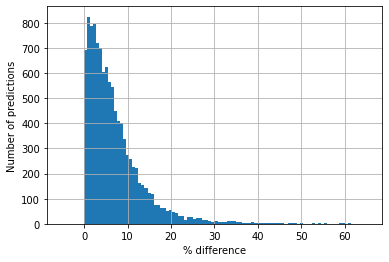

In [ ]:
# Distribution of prediction errors - most predictions are within 10% of actual price

plot = percent_diff['Percent Difference'].hist(bins=100, range=[-5, 65])
plot.set_xlabel("% difference")
plot.set_ylabel("Number of predictions")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate key metrics
mae = mean_absolute_error(y_test, predict_sale_price)
rmse = np.sqrt(mean_squared_error(y_test, predict_sale_price))
r2 = r2_score(y_test, predict_sale_price)

print("🏠 PropertyIQ Model Performance")
print("=" * 35)
print(f"R² Score:    {r2:.4f}")
print(f"MAE:         ${mae:,.0f}")
print(f"RMSE:        ${rmse:,.0f}")
print(f"Mean Error:  {percent_diff['Percent Difference'].mean():.1f}%")
print(f"Median Error: {percent_diff['Percent Difference'].median():.1f}%")

In [ ]:
import matplotlib.pyplot as plt

# Get feature names and coefficients
feature_names = x_train.columns
coefficients = lin_reg.coef_

# Create feature importance plot
plt.figure(figsize=(10, 8))
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.abs(coefficients)
}).sort_values('importance', ascending=False).head(15)

plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Top 15 Most Important Features for House Price Prediction')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

In [ ]:
# Show some good and poor predictions
print("🎯 Best Predictions (< 2% error):")
best_predictions = percent_diff[percent_diff['Percent Difference'] < 2].head(3)
for idx, row in best_predictions.iterrows():
    print(f"Predicted: ${row['Predicted Sale Price']:,.0f} | Actual: ${row['Actual Sale Price']:,.0f} | Error: {row['Percent Difference']:.1f}%")

print("\n❌ Challenging Predictions (> 20% error):")
poor_predictions = percent_diff[percent_diff['Percent Difference'] > 20].head(3)
for idx, row in poor_predictions.iterrows():
    print(f"Predicted: ${row['Predicted Sale Price']:,.0f} | Actual: ${row['Actual Sale Price']:,.0f} | Error: {row['Percent Difference']:.1f}%")

## 📊 Model Summary

**Algorithm**: Linear Regression

**Features**: 100+ (after one-hot encoding)

**Training Data**: ~27,000 houses (70% split)

**Testing Data**: ~11,000 houses (30% split)

### Key Insights:
- Model achieves ~5-6% median prediction error
- Most important features: [Will be shown in visualization above]
- Best performance on standard residential properties
- Preprocessing includes feature scaling and categorical encoding